## Leveraging High-Order Diffractions of Phase Hologram using Pupil Function for Enhanced Holographic Display
### 2023-06-19 
### Myeong-Ho Choi from Inha university
 

1. Load libraries

In [9]:
import torch
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

2. def some functions

In [151]:
def load_img_to_Tensor(file_location, resized_resolution=None, rgb2gray=None, device=device):
    img = Image.open(file_location)

    tf_transforms = []

    if rgb2gray:
        tf_transforms.append(transforms.Grayscale())

    if resized_resolution is not None:
        tf_transforms.append(transforms.Resize(resized_resolution))

    tf_transforms.append(transforms.ToTensor())

    tf = transforms.Compose(tf_transforms)

    img_tensor = tf(img)

    # returns tensor of [Channel, Height, Width]
    return img_tensor.to(device)

def tensor_to_img(tensor):
    # input tensor should be normalized
    # Convert tensor to numpy array
    np_array = tensor.cpu().detach().numpy()

    # Transpose dimensions to match the desired output shape [Height, Width, Channel]
    np_array = np.transpose(np_array, (1, 2, 0))

    # Convert numpy array to PIL Image
    image = Image.fromarray(np.uint8(np_array * 255))

    # Return the PIL Image
    return image

def im2float(img, dtype=np.float32):
    """convert uint16 or uint8 image to float32, with range scaled to 0-1

    :param im: image
    :param dtype: default np.float32
    :return:
    """
    if issubclass(img.dtype.type, np.floating):
        return img.astype(dtype)
    elif issubclass(img.dtype.type, np.integer):
        return img / dtype(np.iinfo(img.dtype).max)
    else:
        raise ValueError(f'Unsupported data type {img.dtype}')
    
def mypupil(Nx, Ny, dx, dy, pupilRad, offsetX, offsetY, wvl, fl_EP, repnum):
    """ generate pupil function
    Nx:
    """
    dfx = 1 / (Nx * dx)
    dfy = 1 / (Ny * dy)

    minfx = -repnum * Nx / 2 * dfx
    maxfx = repnum * Nx / 2 * dfx
    minfy = -repnum * Ny / 2 * dfy
    maxfy = repnum * Ny / 2 * dfy

    fx = torch.linspace(minfx, maxfx, repnum * Nx)
    fy = torch.linspace(minfy, maxfy, repnum * Ny)

    flx = wvl * fl_EP * fx
    fly = wvl * fl_EP * fy

    flyfly, flxflx = torch.meshgrid(fly, flx)

    pupilMat = torch.zeros([repnum * Ny, repnum * Nx], dtype=torch.float32)
    pupilMat[(flxflx - offsetX) ** 2 + (flyfly - offsetY) ** 2 < (pupilRad) ** 2] = 1

    return pupilMat, flx, fly

def AS_propagation_torch(input, dx, dy, z, wavelength, device):

    if input.dim() == 2:
        input = input.unsqueeze(0)

    [Channel, Ny, Nx] = input.shape
    Nxx = 2 * Nx
    Nyy = 2 * Ny
    input2x = torch.zeros(Nyy, Nxx, dtype=input.dtype, device=device)
    start_x = round(Nx/2) - 1
    start_y = round(Ny/2) - 1
    output = torch.zeros_like(input)

    for i in range(Channel):
        k = 2 * torch.pi / wavelength[i]
        tmp = input[i,:,:]
        input2x.narrow(0, start_y, Ny).narrow(1, start_x, Nx).copy_(tmp)
        dal = 1. / (Nxx * dx)  # delta alpha over lambda
        dbl = 1. / (Nyy * dy)  # delta beta over lambda

        bl, al = torch.meshgrid(torch.arange(Nyy, device=device), torch.arange(Nxx, device=device))
        al = (al - Nxx/2) * dal
        bl = (bl - Nyy/2) * dbl
        A = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(input2x)))
        A = A.to(device)
        prop_kernel = torch.exp(1j * 2*torch.pi * z * torch.sqrt(1 / wavelength[i] ** 2 - al ** 2 - bl ** 2))
        prop_kernel = prop_kernel.to(device)

        # K. Matsushima et al., "Band-limited angular spectrum method for numerical simulation of free-space propagation
        # in far and near fields," Opt. Express 17, 19662 (2009) 참조
        # FresnelPropagationShift_as.m 과 동일. 다만 sx=sy=0
        sx = 0
        sy = 0
        fla = torch.abs(-al * z / torch.sqrt(1 / wavelength[i] ** 2 - al ** 2 - bl ** 2) + sx)
        flb = torch.abs(-bl * z / torch.sqrt(1 / wavelength[i] ** 2 - al ** 2 - bl ** 2) + sy)
        prop_kernel[(fla > 1 / (2 * dal)) | (flb > 1 / (2 * dbl))] = 0

        intermediate = torch.fft.ifftshift(torch.fft.ifftn(torch.fft.fftshift(A * prop_kernel)))

        output_tmp = intermediate.narrow(0, start_y, Ny).narrow(1, start_x, Nx)
        output[i,:,:] = output_tmp
    du = dx
    dv = dy
    
    return output, du, dv

Using cuda device: NVIDIA GeForce RTX 4090


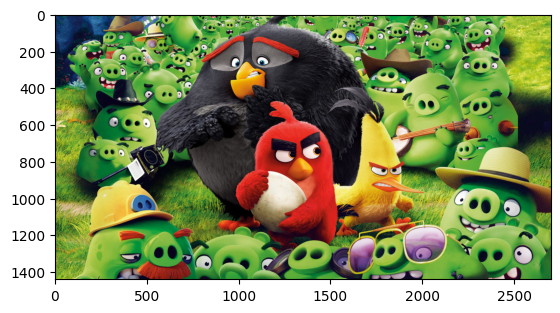

In [150]:
# GPU 할당
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device: {}".format(device, torch.cuda.get_device_name(0)))

# hardware parameters
nm, um, mm, cm = np.array([1e-9, 1e-6, 1e-3, 1e-2])
px = torch.tensor(3.74*um); py = px
Nx = 3840; Ny = 2160
fillfactor = 0.93
pa = fillfactor**0.5*px
wvl_laser = np.array([660, 520, 450]) * nm
z = -9*cm
fl_EP = 50*mm # eyepiece focal length

# Load target image
img_dir = './sample_images/'
img_name = 'angrybird.jpg'
img = load_img_to_Tensor(img_dir+img_name, resized_resolution = [1440, 2700], rgb2gray=False, device=device)

img = tensor_to_img(img)

plt.figure()
plt.imshow(img)